In [1]:
%load_ext autoreload
%autoreload 2
import os; import sys;src_dir = os.path.join(os.getcwd(), os.pardir, 'src');sys.path.append(src_dir)

In [2]:
from data.dal import DAL
import pandas as pd
import numpy as np
import dtaidistance
from dtaidistance import dtw
from tqdm import tqdm
import models.nndtw as nn
import sklearn.model_selection
import sklearn.model_selection

In [5]:
features = DAL("features.hdf")

In [8]:
features.overview()
dfs = [v for k,v in features.get("angles_raw").groupby("id")]
#dfs =[split.get(k) for k in split.overview().df_key]
dfs[0]

,KneeRight_AnkleRight_FootRight,WristRight_HandRight_HandTipRight,HipRight_KneeRight_AnkleRight,SpineBase_HipLeft_KneeLeft,HipLeft_KneeLeft_AnkleLeft,SpineMid_SpineBase_HipRight,SpineMid_SpineBase_HipLeft,HipRight_SpineBase_HipLeft,SpineShoulder_ShoulderRight_ElbowRight,SpineShoulder_SpineMid_SpineBase,...,Head_Neck_SpineShoulder,Neck_SpineShoulder_SpineMid,Neck_SpineShoulder_ShoulderRight,Neck_SpineShoulder_ShoulderLeft,SpineMid_SpineShoulder_ShoulderRight,SpineMid_SpineShoulder_ShoulderLeft,ShoulderRight_SpineShoulder_ShoulderLeft,SpineBase_HipRight_KneeRight,ShoulderRight_ElbowRight_WristRight,id
71,2.148486,2.944258,2.871209,1.749046,2.846954,1.621643,1.615389,2.153157,2.523721,3.110267,...,2.964004,3.100969,1.886017,1.898566,1.245347,1.231099,2.291718,1.681057,2.937488,0
72,2.120414,2.992398,2.853957,1.751826,2.827030,1.620823,1.616768,2.153423,2.522989,3.110155,...,2.961826,3.100842,1.885922,1.898274,1.245822,1.231036,2.293443,1.676915,2.937044,0
73,2.110667,2.941838,2.867684,1.750591,2.827266,1.621241,1.616435,2.153712,2.539160,3.110268,...,2.962559,3.100815,1.899608,1.898371,1.231471,1.230877,2.271502,1.678363,2.943024,0
74,2.112273,2.921071,2.869253,1.751324,2.825425,1.621769,1.616127,2.157616,2.538430,3.110479,...,2.962717,3.100933,1.897685,1.899277,1.233523,1.230036,2.274382,1.677435,2.943618,0
75,2.112673,2.972160,2.872655,1.750969,2.831556,1.621096,1.615661,2.162000,2.540467,3.110897,...,2.964051,3.101228,1.898966,1.897666,1.232114,1.232032,2.276289,1.676220,2.942888,0
76,2.115777,2.954902,2.874422,1.750594,2.820167,1.619867,1.615654,2.168392,2.540556,3.111106,...,2.962584,3.101264,1.898443,1.897427,1.232687,1.232299,2.277814,1.677330,2.940822,0
77,2.122502,2.971141,2.873157,1.750511,2.822095,1.620045,1.615558,2.167978,2.541371,3.111344,...,2.962116,3.101225,1.898867,1.927955,1.232221,1.199254,2.211799,1.678265,2.938267,0
78,2.127775,2.879583,2.871760,1.750910,2.829404,1.620249,1.615869,2.163223,2.542877,3.111316,...,2.962647,3.101315,1.899271,1.918726,1.231942,1.209256,2.232807,1.678056,2.936967,0
79,2.130748,2.941553,2.872574,1.755186,2.824731,1.613691,1.619756,2.157102,2.541170,3.111241,...,2.963435,3.101132,1.896571,1.915581,1.234723,1.212786,2.246846,1.668244,2.936240,0
80,2.135448,2.817432,2.872429,1.753361,2.816735,1.614278,1.617743,2.157868,2.540256,3.111401,...,2.963436,3.101419,1.894059,1.910618,1.237525,1.218361,2.264835,1.668953,2.936746,0


In [9]:
dm = nn.distance_matrix(dfs)
np.save("../data/distance_matrix_angles.npy",dm)

100%|██████████| 30/30 [1:13:34<00:00, 147.16s/it]


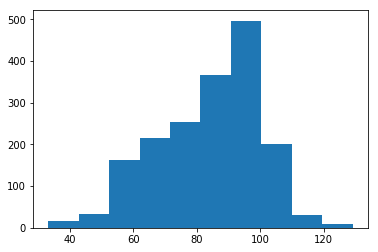

In [11]:
import matplotlib.pyplot as plt
dm = np.load("../data/distance_matrix_angles.npy")
plt.hist(dm[2][5:])
plt.show()

In [13]:
split = DAL("split.hdf")
labels = split.overview()
labels["correct"] = labels.execution_type == 1
X = np.array(list(range(0,len(labels))))
sets = [int(x.replace("skeleton_","")) //100 for x in labels.df_key]
cv2 = lambda : sklearn.model_selection.GroupKFold(10).split(X,groups=sets)
cv3 = lambda : sklearn.model_selection.GroupKFold(10).split(X,groups=labels.person)

clf = nn.DTWClassifier("../data/distance_matrix_angles.npy")
results = []
for t in ["exercise","correct","execution_type"]:
    y = labels[t].values
    exercisetrans = sklearn.preprocessing.LabelEncoder()
    y = exercisetrans.fit_transform(y)
    for cvname,cv in [("Leave-one-set-out CV",cv2),
                    ("Leave-one-subject-out CV",cv3)]:
        scores = sklearn.model_selection.cross_validate(clf,X,y,cv=cv(),return_train_score=True,scoring="accuracy")
        result = (t,"DTW",cvname,scores)
        print(result)
        results.append(result)

('exercise', 'DTW', 'Leave-one-set-out CV', {'fit_time': array([0.00408816, 0.00360632, 0.00351453, 0.00350738, 0.00350881,
       0.00352168, 0.0034945 , 0.00351286, 0.00352478, 0.00353336]), 'score_time': array([0.00149369, 0.0012064 , 0.00109768, 0.00108171, 0.00104308,
       0.00106025, 0.00104141, 0.00105906, 0.00104904, 0.0010643 ]), 'test_score': array([1.        , 1.        , 1.        , 0.97222222, 0.99435028,
       1.        , 1.        , 1.        , 1.        , 1.        ]), 'train_score': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])})
('exercise', 'DTW', 'Leave-one-subject-out CV', {'fit_time': array([0.00349927, 0.00348139, 0.00352049, 0.00351906, 0.00349188,
       0.0034709 , 0.00350571, 0.00351548, 0.00351071, 0.00347996]), 'score_time': array([0.00119019, 0.00117588, 0.0011456 , 0.00113392, 0.00114226,
       0.0011282 , 0.00111938, 0.00109243, 0.00108123, 0.00107741]), 'test_score': array([0.99468085, 1.        , 0.96703297, 0.99447514, 1.        ,
       0.99438

In [14]:
import scipy.stats as stats

res = pd.DataFrame(results,columns=["y","clf","cv","scores"])

def summarize(scores):
    s = scores["test_score"]
    lo,hi = stats.t.interval(alpha = 0.95,              # Confidence level
                 df= len(s)-1,                    # Degrees of freedom
                 loc = s.mean(),         # Sample mean
                 scale = s.std())
    return s.mean()#"%.3f pm %.3f" % ((lo+hi)/2,(hi-lo)/2)

def t(y):
    if y == "exercise":
        return "t1"
    if y == "correct":
        return "t2"
    if y == "execution_type":
        return "t3"
def shortcv(cv):
    if cv == "Leave-one-set-out CV":
        return "$CV_{set}$"
    if cv == "Leave-one-subject-out CV":
        return "$CV_{subject}$"
    
res["t"] = res.y.apply(t)
res["scores"] = res.scores.apply(summarize)
res["shortcv"] = res.cv.apply(shortcv)

#res = res[res.y == "execution_type"]
#res.pivot(index=0,columns=1,values=2)
#print(res.pivot(index="clf",columns="cv",values="scores").to_latex())
df = res.pivot_table(index="clf",columns=["t","shortcv"],values="scores")

print(df.applymap(lambda x: '%.3f' % x).to_latex())

\begin{tabular}{lllllll}
\toprule
t & \multicolumn{2}{l}{t1} & \multicolumn{2}{l}{t2} & \multicolumn{2}{l}{t3} \\
shortcv & \$CV\_\{set\}\$ & \$CV\_\{subject\}\$ & \$CV\_\{set\}\$ & \$CV\_\{subject\}\$ & \$CV\_\{set\}\$ & \$CV\_\{subject\}\$ \\
clf &            &                &            &                &            &                \\
\midrule
DTW &      0.997 &          0.990 &      0.713 &          0.648 &      0.576 &          0.549 \\
\bottomrule
\end{tabular}



In [ ]:
totaldist = dists[0].copy()
for i in range(1,len(dists)):
    totaldist += dists[i]

printm(totaldist)

In [ ]:
#print(dists)
#print(totaldist)
def printm(m):
    for row in m:
        print(["%.1f" % x for x in row])
for d in dists:
    printm(d)
printm(totaldist)